In [1]:
#this notebook includes making different models, testing them, and making predictions
#the necessary libraries are imported below
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

/home/kooloosh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
#data prepration steps including reading the files, splitting it into train and test and at last standardizing it
#this list provides the name of the chosen columns
pr_pca = ['clwvi(1)', 'zg0(1)', 'hur6(1)', 'vas(2)', 'uas(2)', 'hus0(3)']
#reading the csv files using pandas and making the required dataset for our use
X = pd.read_csv('data/allpoints.csv')
X = X.loc[:, pr_pca]
y = pd.read_csv('data/y_pr.csv')

#splitting the data into train and test datasets for further prepration and modeling with the test size of 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

#scaling the data in a fashion to prevent leakage
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [3]:
#defining accuracy measure functions to test out the models
def DC(y_true, y_pred):
    y_true = np.array(y_true, dtype=np.float32)[:, 0]
    y_pred = np.array(y_pred, dtype=np.float32)[:, 0]
    metric = tfa.metrics.r_square.RSquare()
    metric.update_state(y_true, y_pred)
    result = metric.result()
    return result.numpy()
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [5]:
#creating the desired model
#the while loop below is designed to run different networks with similar attributes
#this yields in achieving the best performing model
#the conditions include the DC value for train and validation datasets
dc_v = 0.0
dc_t = 0.0
while dc_v <= 0.31 or dc_t < dc_v:
    #the model consists of the activation function of tanh and the neuron counts can be modified easily
    model = keras.Sequential([
        layers.Dense(8, activation='tanh', input_shape=[X_train.shape[1]]),
        layers.Dense(1)
    ])
    
    #the line below specifies an optimizer and loss function for the model
    model.compile(
        optimizer='adam',
        loss='mse'
    )

    data = {
            'val_RMSE' : [],
            'val_DC' :[],
            'train_RMSE' : [],
            'train_DC' : [],
            'epochs' : []
    }
    
    #this object will help preventing useless training epochs, also reduces the chance of under training
    early_stopping = EarlyStopping(
                min_delta=0.001,
                patience=30,
                restore_best_weights=True
    )
    
    #fitting the model to train datasets with 16 sized batches
    #note that 1000 epochs here is just to give some freedom to the early stopping method
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=16,
        epochs=1000,
        callbacks=[early_stopping],
        verbose=0
    )
    
    #and this part calcutes the accuracy of the model
    #it's worth noting that RMSE was calculatede after reversing the standardization of y
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    hist_df = pd.DataFrame(hist.history)
    data['val_RMSE'].append(float(root_mean_squared_error((scaler_y.inverse_transform(y_test)), (scaler_y.inverse_transform(y_pred)))))
    data['val_DC'].append(DC(y_test, y_pred))
    data['train_RMSE'].append(float(root_mean_squared_error((scaler_y.inverse_transform(y_train)), (scaler_y.inverse_transform(y_pred_train)))))
    data['train_DC'].append(DC(y_train, y_pred_train))
    data['epochs'].append(len(hist.epoch))
    
    dc_v = float(data['val_DC'][0])
    dc_t = float(data['train_DC'][0])
print(pd.DataFrame(data))

2022-05-14 12:34:25.576307: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-14 12:34:25.577676: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 12:34:25.579652: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-14 12:34:25.732501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-14 12:34:25.740767: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2807995000 Hz


    val_RMSE    val_DC  train_RMSE  train_DC  epochs
0  18.906971  0.312354   18.858053  0.350747      94


Minimum Validation Loss: 0.6519516110420227


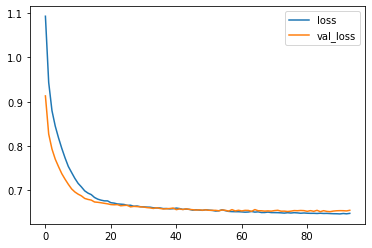

In [9]:
#the figure below can help us preventing over and under training 

history_df = pd.DataFrame(hist.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print(f'Minimum Validation Loss: {history_df["val_loss"].min()}')

In [7]:
#we can save the model in the model folder with this piece of code and load it later on for predictions
model.save('models/pr-pca.h5')

#to load the load we use load_model module
model = load_model('models/pr-pca.h5')

In [8]:
#we should not forget after getting good results from the model
#we need to train the model on validation sets as well
#we do it while we keep track of DC so our model doesnt go out of tune

hist_test = model.fit(
        X_test, y_test,
        batch_size=16,
        epochs=10,
        verbose=0
    )

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
dc = DC(y_test, y_pred)
dc

0.32523495

In [ ]:
#with loading the future scenarios we can start predicting the future
#we also need to remember to standardize the predictors 
#after predicting we need to inverse scaling on predictions

X_ssp245 = pd.read_csv('data/ssp245-pca-pr.csv')
X_ssp245.columns = X.columns
X_ssp245 = scaler_X.transform(X_ssp245)
X_ssp585 = pd.read_csv('data/ssp585-pca-pr.csv')
X_ssp585.columns = X.columns
X_ssp585 = scaler_X.transform(X_ssp585)

y_ssp245 = model.predict(X_ssp245)
y_ssp585 = model.predict(X_ssp585)

y_245unscaled = pd.Series(scaler_y.inverse_transform(y_ssp245)[:, 0], name='pr-245', index=None)
y_585unscaled = pd.Series(scaler_y.inverse_transform(y_ssp585)[:, 0], name='pr-585', index=None)

#we now save the predictons in output folder
y_245unscaled.to_csv('output/prediction_pr_245.csv', index=False)
y_585unscaled.to_csv('output/prediction_pr_585.csv', index=False)

In [10]:
#in this part we run a MLR model for comparison purposes
#the steps of data prepration is repeated here to prevent biases

from sklearn import linear_model

X = pd.read_csv('data/allpoints.csv')
y = pd.read_csv('data/y_tm.csv')

pr_pca =['clwvi(1)', 'zg0(1)', 'hur6(1)', 'vas(2)', 'uas(2)', 'hus0(3)']
tm_pca = ['hurs(1)', 'clwvi(1)', 'psl(1)', 'tas(1)', 'va0(2)', 'ua2(4)']
X = X.loc[:, tm_pca]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

def DC(y_true, y_pred):
    y_true = np.array(y_true, dtype=np.float32)[:, 0]
    y_pred = np.array(y_pred, dtype=np.float32)[:, 0]
    metric = tfa.metrics.r_square.RSquare()
    metric.update_state(y_true, y_pred)
    result = metric.result()
    return result.numpy()

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_train = regr.predict(X_train)
y_pred_test = regr.predict(X_test)

dc_train = DC(y_train, y_pred_train)
dc_test = DC(y_test, y_pred_test)

LinearRegression()